# **Proyecto 1 - Etapa 1**

## **Importaciones**

In [214]:
import re
import unicodedata

import matplotlib.pyplot as plt
import nltk
import pandas as pd
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('spanish')
wpt = nltk.WordPunctTokenizer()
ps = PorterStemmer()
import re
import unicodedata
from collections import Counter

import nltk
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Entendimiento y Preparación de los Datos**

### **Entendimiento**

Se importan los datos.

In [215]:
original_data = pd.read_excel('data/Datos_proyecto.xlsx')

print("Dimensiones:", original_data.shape, "\n")

print("Tipos de datos por columna:")
print(original_data.dtypes)

display(original_data.head())

print("\nValores únicos por columna:")
print(original_data.nunique())

Dimensiones: (2424, 2) 

Tipos de datos por columna:
textos    object
labels     int64
dtype: object


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3



Valores únicos por columna:
textos    2424
labels       3
dtype: int64


El conjunto de datos únicamente tiene 2 columnas. A continuación, se define el diccionario de datos a partir de la información proveida en el enunciado y de la inspección inicial de los encabezados del conjunto de datos.

| Atributo | Descripción |
|----------|-------------|
| textos | String conteniendo opiniones de la ciudadanía provenientes de distintas fuentes vinculadas a la planificación participativa territorial. |
| labels | Integer $\in$ {1, 3, 4} que indica el objetivo de desarrollo sostenible (ODS) para el cual es más relevante la opinión dada en un texto; 1 es "Fin de la pobreza", 3 es "Salud y bienestar" y 4 es "Educación de calidad". |

Hay 2424 filas y 2 columnas. La columna de textos está guardada como el tipo genérico object, pero esto se cambiará en la etapa de validez. Adicionalmente, todos los textos son únicos y solo hay 3 clases en la variable objetivo, lo cual es correcto puesto que solo deben clasificarse las opiniones en los ODS 1, 3 y 4.

Inicialmente, se observa que en los datos proveídos y en el contexto del enunciado no se especificó:
- Los posibles idiomas de los textos, pero se preguntó al negocio y se confirmó que todos los textos estarán en español.
- Si hay longitudes mínimas o máximas para los textos. Esto se preguntó al negocio, pero solo se obtuvo la respuesta de que los textos siempre van a ser "opiniones cortas".
- Si los textos pueden contener carácteres especiales.
- El contexto geográfico y demográfico del que provienen los textos.
- Los criterios usados para asignar las etiquetas a los textos.

Estas limitaciones deberán ser tomadas en cuenta en el perfilamiento y preprocesamiento y, eventualmente, en el análisis puesto que pueden influir en la interpretación de resultados y en la validez de los métodos aplicados.

### **Perfilamiento de los Datos**

Como en el entendimiento se verificó que efectivamente solo aparecen los labels 1, 3 y 4, se procede a revisar la distribución de las clases.

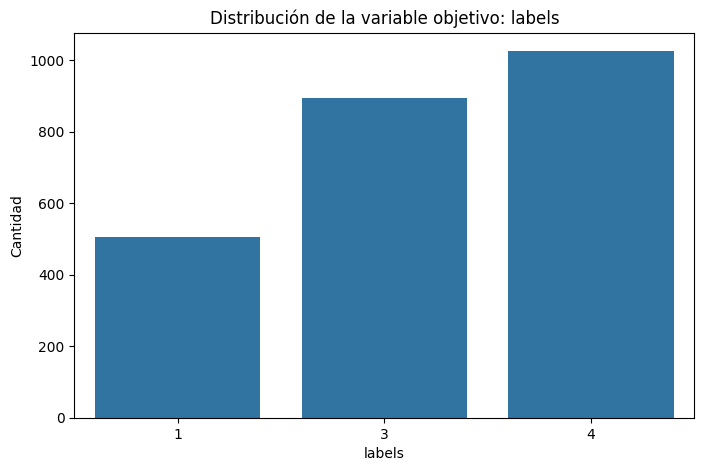

labels
4    1025
3     894
1     505
Name: count, dtype: int64


In [216]:
plt.figure(figsize=(8, 5))
sns.countplot(data=original_data, x='labels')
plt.title('Distribución de la variable objetivo: labels')
plt.ylabel('Cantidad')
plt.show()

label_counts = original_data['labels'].value_counts()
print(label_counts)

Hay desbalance en las clases, siendo la clase 4 la más representada con 1025 filas, seguida por la clase 3 con 894 filas y finalmente por la clase 1 con 505 filas. Esto puede afectar el rendimiento del modelo, sin embargo, la aumentación de datos para intentar balancear las clases se hará hasta la etapa 2 del proyecto.

Dado que en el entendimiento se verificó que los textos son únicos, se procede a revisar varias carácterísticas de los textos para entender mejor el conjunto de datos.

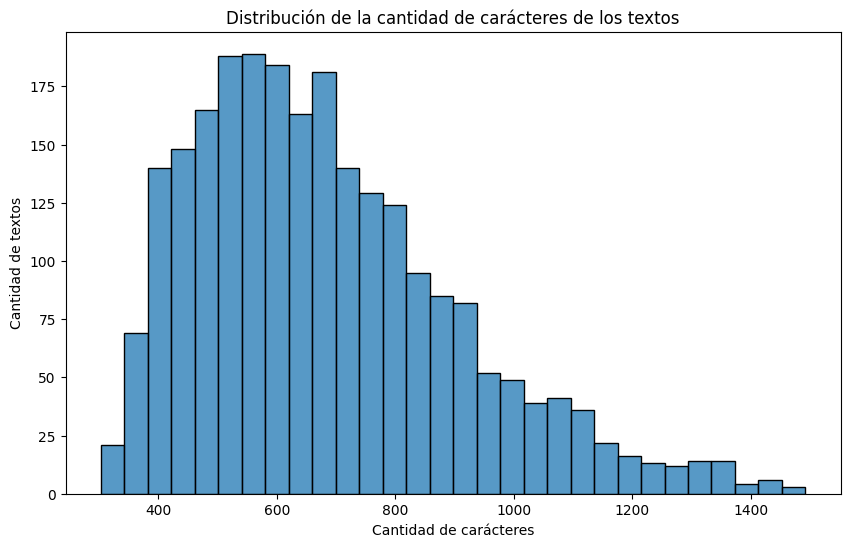

Estadísticas descriptivas de la cantidad de carácteres de los textos:
count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: textos, dtype: float64


In [217]:
text_character_counts = original_data['textos'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(text_character_counts, bins=30)
plt.title('Distribución de la cantidad de carácteres de los textos')
plt.xlabel('Cantidad de carácteres')
plt.ylabel('Cantidad de textos')
plt.show()

print("Estadísticas descriptivas de la cantidad de carácteres de los textos:")
print(text_character_counts.describe())

La distribución de la longitud de los textos, en cantidad de carácteres, sigue una distribución aproximadamente normal, con una media de 683.22 carácteres y una desviación estándar de 223.56 carácteres. El texto más corto tiene 303 carácteres y el más largo tiene 1492 carácteres. A pesar de que la distribución es aproximadamente normal, hay una ligera asimetría en el costado derecho, lo cual indica que hay algunos textos considerablemente más largos que la media. Una alta presencia de textos largos podría ser problemático para algunos tipos de vectorización y modelos, pero debido a la distribución observada, no se espera que esto sea un problema significativo. En particular, se observa que el percentil 75 es 809.25 carácteres, lo cual se encuentra a menos de una desviación estándar de la media, indicando que la mayoría de los textos no son largos relativo a la media.

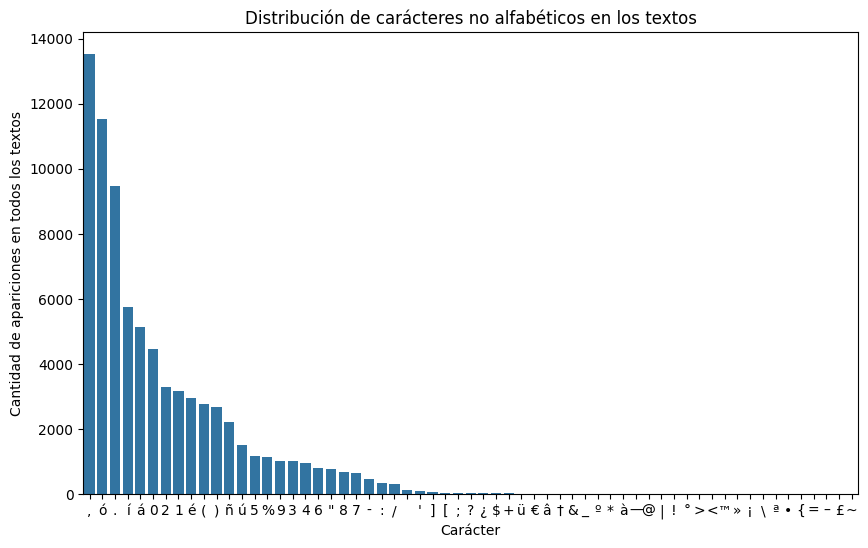

   character  count
3          ,  13523
1          ó  11536
2          .   9458
9          í   5750
4          á   5133
..       ...    ...
47         {      1
57         =      1
58         –      1
59         £      1
60         ~      1

[61 rows x 2 columns]
Estadísticas descriptivas de la cantidad de carácteres no alfabéticos:
count       61.000000
mean      1286.147541
std       2719.823572
min          1.000000
25%          4.000000
50%         35.000000
75%       1014.000000
max      13523.000000
Name: count, dtype: float64


In [218]:
text_non_alpha_chars = original_data['textos'].str.lower().str.findall(r'[^a-zA-Z\s]', flags=re.UNICODE)
all_non_alpha_chars = [char for sublist in text_non_alpha_chars for char in sublist]
non_alpha_char_counts = Counter(all_non_alpha_chars)

non_alpha_char_counts_df = pd.DataFrame(non_alpha_char_counts.items(), columns=['character', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=non_alpha_char_counts_df, x='character', y='count')
plt.title('Distribución de carácteres no alfabéticos en los textos')
plt.xlabel('Carácter')
plt.ylabel('Cantidad de apariciones en todos los textos')
plt.show()

print(non_alpha_char_counts_df)

print("Estadísticas descriptivas de la cantidad de carácteres no alfabéticos:")
print(non_alpha_char_counts_df['count'].describe())

En la gráfica se muestra la distribución de la cantidad de carácteres especiales, i.e. no alfabéticos, en los textos habiendo pasado los textos a minúsculas puesto que en la normalización se planea pasar todos los textos a minúsculas.

Hay una cantidad importante de caracteres especiales en los textos, esto es importante tenerlo en cuenta al momento de normalizar los textos. La cantidad de caracteres especiales por texto sigue una distribución que parece decaer como una exponencial negativa. Hay un promedio de 1207 caracteres especiales por texto, con una desviación estándar de 2650.59, lo cual indica que hay una alta variabilidad en la cantidad de caracteres especiales entre los textos. El carácter especial más común es la coma ',' con 13523 apariciones, seguido por: ó, el punto '.', í, á, 0, 2, 1 y é. Dichos carácteres especiales indican que, para perder menos significado al normalizar los textos, se debería considerar conservar las letras acentuadas y los números de algún modo.

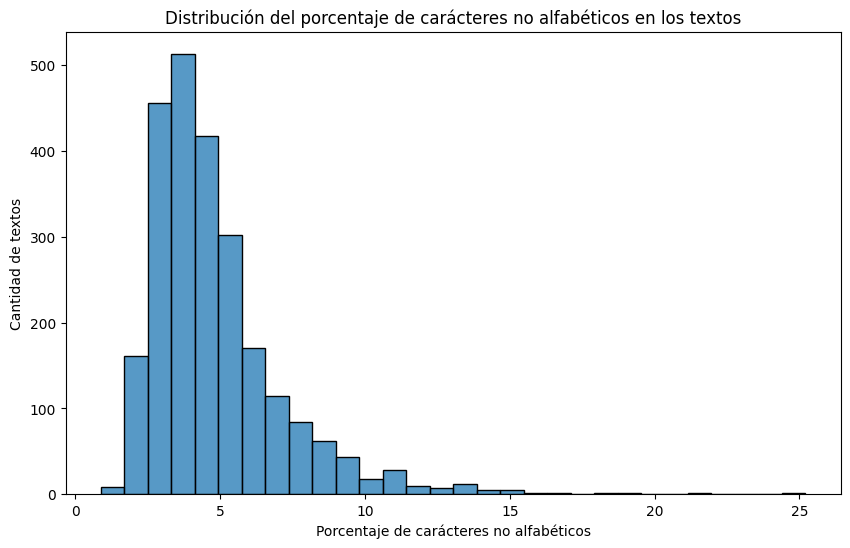

,special_char_percentage
631,25.208681
1695,21.644295
524,18.823529
546,18.701095
550,16.964286
254,15.588235
951,15.360502
1318,15.257048
2109,15.158371
721,15.025907


Estadísticas descriptivas del porcentaje de carácteres no alfabéticos por texto:
count    2424.000000
mean        4.800697
std         2.289457
min         0.878294
25%         3.276147
50%         4.240919
75%         5.604861
max        25.208681
Name: special_char_percentage, dtype: float64


In [219]:
special_char_percentages = [(len(na_chars)/total)*100 for na_chars, total in zip(text_non_alpha_chars, text_character_counts)]

special_char_percentages_df = pd.DataFrame({
    'special_char_percentage': special_char_percentages
})

plt.figure(figsize=(10, 6))
sns.histplot(special_char_percentages_df['special_char_percentage'], bins=30)
plt.title('Distribución del porcentaje de carácteres no alfabéticos en los textos')
plt.xlabel('Porcentaje de carácteres no alfabéticos')
plt.ylabel('Cantidad de textos')
plt.show()

special_char_percentages_df.sort_values(by='special_char_percentage', ascending=False, inplace=True)
display(special_char_percentages_df.head(15))

print("Estadísticas descriptivas del porcentaje de carácteres no alfabéticos por texto:")
print(special_char_percentages_df['special_char_percentage'].describe())

En esta gráfica se muestra la distribución del porcentaje de carácteres especiales presente en los textos. Se observa que la mayoría de textos tienen entre menos de 6% de sus carácteres como carácteres especiales. En promedio, el 4.8% de los carácteres de los textos son carácteres especiales, con una desviación estándar de 2.29%. Esta baja presencia de carácteres especailes es consistente con lo que uno esperaría encontrar en textos reales en español, pues la gran mayoría carácteres deberían ser alfabéticos. Note que esta distribución no tiene mayor relevancia al momento de decidir que tan significativa es la presencia de carácteres especiales al momento de codificar el significado de los textos, puede que sean pocos caractéres especiales, pero que tengan alto impacto en el significado de ciertas palabras en los textos, afectando entonces su clasificación.

Debajo de la gráfica, se muestra una tabla con los 15 textos que tienen mayor porcentaje de carácteres especiales. A continuación, se muestran dichos textos.

In [220]:
for index, row in special_char_percentages_df.head(15).iterrows():
    print(f"Texto {index}: {original_data['textos'].iloc[index]}\n")

Texto 631: Hijos de la austeridad: impacto de la gran recesión en la pobreza infantil en los países ricos, Oxford University Press, http://dx.doi.org/10.1093/oso/9780198797968.003.0012. ¡La Geografía de la I5 Intergeneracional! Uk/28401/l/Helping Patents to Parent report.pdf (consultado el 7 de agosto de 2018). Org/p/hdl/improv/1608.html (consultado el 11 de abril de 2018). Org/file:///C:/Users/thevenon o/Downloads/4448-157-5923-l-10-20180213.pdf. Handbook of labor Economics, 4A, https://economics.ubc.ca/files/2013/05/pdf paper nicole-fortin-decomposition-methods.pdf (consultado el 10 de abril de 2018).

Texto 1695: En 2016, las mayores tasas de incidencia de ITS se registraron en Bayankhongor (36,5 casos por 10.000), Domod (34,7), Sukhbaatar (31,5), Khuvsgul (26,5), Govi-Altai (24,0), Tuv (23,7), Govisumber (23,6) y Domogovi (21,3) Aimags y la ciudad de Ulán Bator (22,2). La morbilidad de la tricomoniasis es más elevada en los aimags de Domod (60,7), Bayankhongor (53,3), Bulgan (17,5)

Se puede observar que esta alta presencia de carácteres especiales, que en principio podría indicar problemas con los textos correspondientes, no necesariamente implica que los registros son incorrectos o que no aportan información relevante. Por ejemplo, el texto 631, i.e. el de mayor presencia de carácteres especiales, es extraño, no parece un comentario de un ciudadano puesto que parece solo ser un conjunto de referencias a otros documentos, pero el texto 1695, i.e. el de segunda mayor presencia de carácteres especiales, tiene mas contenido sustancioso pues incluye varias estadísticas para al final concluir sobre la "incidencia de la infección por VIH". Por lo tanto, registros con una alta presencia de carácteres especiales no se eliminarán del conjunto de datos.

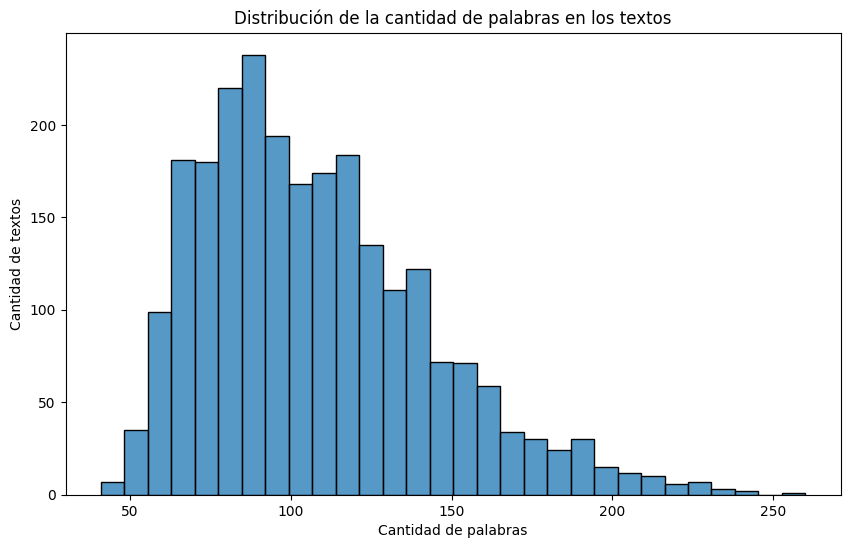

Estadísticas descriptivas de la cantidad de palabras en los textos:
count    2424.000000
mean      107.924092
std        35.575349
min        41.000000
25%        81.000000
50%       102.000000
75%       129.000000
max       260.000000
Name: textos, dtype: float64


In [221]:
text_word_counts = original_data['textos'].str.split().str.len()
plt.figure(figsize=(10, 6))
sns.histplot(text_word_counts, bins=30)
plt.title('Distribución de la cantidad de palabras en los textos')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Cantidad de textos')
plt.show()

print("Estadísticas descriptivas de la cantidad de palabras en los textos:")
print(text_word_counts.describe())

Una medida de longitud de los textos que puede ser más relevante para el análisis es la cantidad de palabras en los textos. La distribución de la cantidad de palabras en los textos sigue una distribución aproximadamente normal, con una media de 107.92 palabras y una desviación estándar de 35.58 palabras. El texto con menos palabras tiene 41 palabras y el texto con más palabras tiene 260 palabras. Similar a la distribución de la cantidad de carácteres, hay una ligera asimetría en el costado derecho, indicando que hay algunos textos considerablemente más largos que la media. Sin embargo, la mayoría de los textos no son excesivamente largos, con el percentil 75 en 129 palabras, lo cual está a menos de una desviación estándar de la media. Todo esto conduce a pensar que la mayoría de textos tienen una longitud razonable y no presentan problemas significativos para la vectorización y modelado en términos de dimensionalidad.

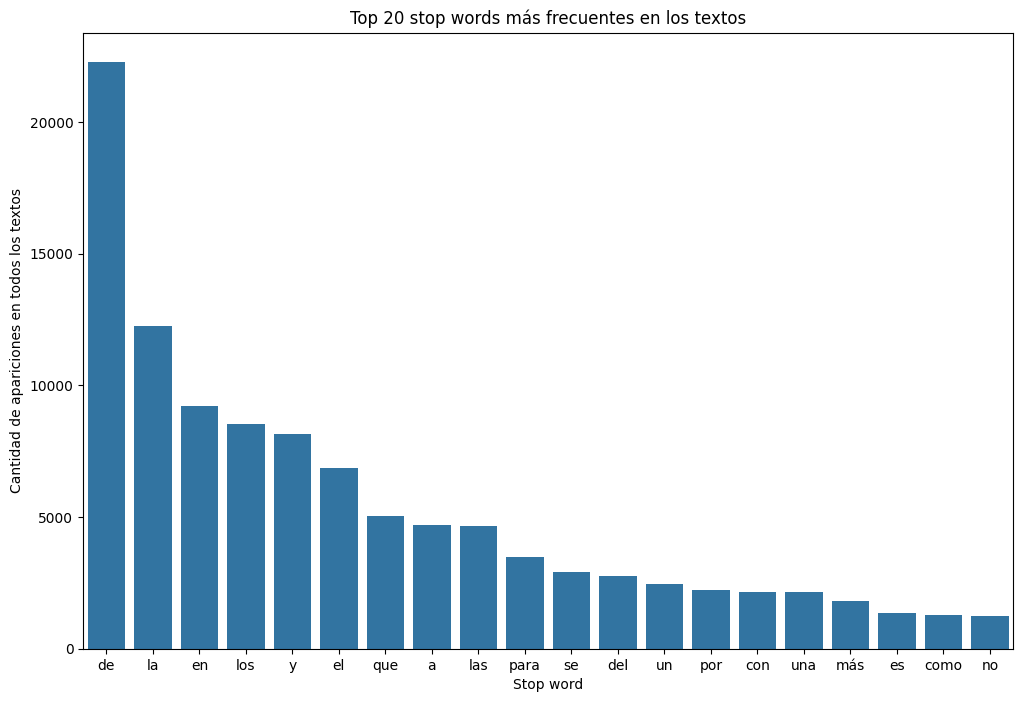

     stop_word  count
0           de  22277
1           la  12256
4           en   9218
7          los   8551
5            y   8137
..         ...    ...
305  tuvieseis      0
309     tenida      0
310    tenidos      0
311    tenidas      0
312      tened      0

[313 rows x 2 columns]
Estadísticas descriptivas de la cantidad de apariciones de stop words:
count      313.000000
mean       393.067093
std       1793.521058
min          0.000000
25%          0.000000
50%          1.000000
75%         50.000000
max      22277.000000
Name: count, dtype: float64


In [222]:
stop_word_counts = {word: original_data['textos'].str.count(rf'\b{re.escape(word)}\b', flags=re.IGNORECASE).sum() for word in stop_words}
stop_word_counts_df = pd.DataFrame(list(stop_word_counts.items()), columns=['stop_word', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=stop_word_counts_df.head(20), x='stop_word', y='count')
plt.title('Top 20 stop words más frecuentes en los textos')
plt.xlabel('Stop word')
plt.ylabel('Cantidad de apariciones en todos los textos')
plt.show()

print(stop_word_counts_df)

print("Estadísticas descriptivas de la cantidad de apariciones de stop words:")
print(stop_word_counts_df['count'].describe())

Hay una cantidad significativa de stop words en los textos, lo cual es esperado en textos que corresponden a las opiniones de personas. Esto también es importante tenerlo en cuenta al momento de normalizar los textos, pues se debería considerar eliminar las stop words para reducir la dimensionalidad y el ruido en los datos.

### **Análisis de Calidad de Datos**

#### **Completitud**

In [223]:
print("Valores nulos por columna:")
print(original_data.isnull().sum())

Valores nulos por columna:
textos    0
labels    0
dtype: int64


No hay valores nulos en ninguna de las columnas.

#### **Unicidad**

In [224]:
print("Cantidad de textos duplicados:")
print(original_data['textos'].duplicated().sum())

Cantidad de textos duplicados:
0


No hay textos duplicados. Note que no se revisan duplicados en labels porque esta variable corresponde a las clases.

#### **Consistencia**

En este caso, no hay nada que evaluar en consistencia. No es posible juzgar si los textos son consistentes con las clases asignadas y no hay otras columnas que deban ser consistentes entre sí.

#### **Validez**

In [225]:
print("Conteo de valores de labels:")
print(original_data['labels'].value_counts())

Conteo de valores de labels:
labels
4    1025
3     894
1     505
Name: count, dtype: int64


Efectivamente solo están las clases 1, 3 y 4 en la variable objetivo.

In [226]:
original_data['textos'] = original_data['textos'].astype('string')

Se cambia el tipo de dato de la columna 'textos' para que sea explícitamente de tipo string.

In [227]:
print("Tipos de datos por columna:")
print(original_data.dtypes)

Tipos de datos por columna:
textos    string[python]
labels             int64
dtype: object


### **Preparación**

Obligatorio:
- Pasar todo a minúsculas.
- Eliminar carácteres especiales irrelevantes.
- Lematización o stemming con librería, pero a priori me suena mejor lematización.
- Eliminar stop words.
- Eliminar no alfabéticos. Será que conviene dejar puntuación? Si se deja puntuación se eliminan caracteres especiales irrelevantes cambiandolos por espacios?
- Se vectoriza de una vez? Creería que sí, pero supongo que es posible que esa representación dependa del algoritmo de clasificación que se use.

En este apartado se realza la normalización, tokenización y vectorización de los textos en preparación para la implementación de los modelos de clasificación. Por un lado, la normalización involucrará pasar los textos a minúsculas, reemplazar carácteres acentuados por sus equivalentes sin acento, reemplazar carácteres numéricos por sus equivalentes en texto, eliminar los carácteres especiales restantes y eliminar las stop words. Por otro lado, la vectorización se realizará usando TF-IDF con n-gramas de tamaño 1 y 2 debido a la naturaleza corta de los textos al ser opiniones ciudadanas. Previo a la vectorización, se realizará tokenización y stemming usando la librería nltk.

In [228]:
nltk.download('punkt')
nltk.download('punkt_tab')

# Funciones de reemplazo
def replace_accents(text: str) -> str:
    normalized = unicodedata.normalize('NFD', text)
    without_accents = ''.join(c for c in normalized if unicodedata.category(c) != 'Mn')
    return without_accents

def replace_numbers_with_text(text: str) -> str:
    num_map = {
        '0': 'cero',
        '1': 'uno',
        '2': 'dos',
        '3': 'tres',
        '4': 'cuatro',
        '5': 'cinco',
        '6': 'seis',
        '7': 'siete',
        '8': 'ocho',
        '9': 'nueve'
    }
    return re.sub(r'\d', lambda m: num_map[m.group()], text)

# Normalización, tokenización y stemming
stemmer = SnowballStemmer("spanish")
spanish_stopwords = set(stopwords.words("spanish"))

def basic_normalize(text: str) -> str:
    """lowercase, reemplazar acentos, reemplazar números, eliminar carácteres especiales"""
    if text is None:
        return ""
    text = str(text).lower().strip()
    text = replace_accents(text)
    text = replace_numbers_with_text(text)
    # dejar solo letras a-z y espacios
    text = re.sub(r'[^a-z\s]', ' ', text, flags=re.UNICODE)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text: str) -> list[str]:
    """Tokenizar usando word_tokenize (nltk.tokenize)"""
    if not text:
        return []
    return word_tokenize(text, language='spanish')

def stem_tokens(tokens: list[str], remove_sw: bool = True) -> list[str]:
    """Aplica SnowballStemmer a la lista de tokens. Opcionalmente quita stopwords."""
    if remove_sw:
        tokens = [t for t in tokens if t not in spanish_stopwords]
    return [stemmer.stem(t) for t in tokens if t.strip()]

def process_text_once(text: str, remove_stopwords: bool = True) -> str:
    """Pipeline por texto: normalize -> tokenize -> optional remove stopwords -> stem -> join."""
    basic = basic_normalize(text)
    toks = tokenize_text(basic)
    stems = stem_tokens(toks, remove_sw=remove_stopwords)
    return " ".join(stems)

def normalize_texts_nltk(series: pd.Series, remove_stopwords: bool = False) -> pd.Series:
    """Aplica process_text_once a una pd.Series de textos."""
    series = series.fillna("").astype(str)
    return series.apply(lambda s: process_text_once(s, remove_stopwords=remove_stopwords))

# Se crea una copia del DataFrame original para no modificarlo
df = original_data.copy()

# Preprocesamiento de textos
df['text_processed'] = normalize_texts_nltk(df['textos'], remove_stopwords=True)

X = df['text_processed']
y = df['labels']

TEST_SIZE = 0.20    # porcentaje final para test
VAL_SIZE = 0.16     # porcentaje final para validation
RANDOM_STATE = 42

# Series de entrada
X = df['text_processed'].astype(str)
y = df['labels'].values

# Proporciones originales de las clases
print("Distribución original (proporciones):")
print(pd.Series(y).value_counts(normalize=True).sort_index())

# 1) Primer split: sacar TEST (manteniendo stratify si es posible)
try:
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
except ValueError as e:
    print("WARNING: stratify falló en la separación test (posible clase con muy pocas muestras).")
    print("Detalle:", e)
    print("Procediendo con split no estratificado para test.")
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=None
    )

# 2) Segundo split: dividir X_temp en TRAIN y VALIDATION
# Queremos que validation tenga VAL_SIZE de todo el dataset.
# Dado que X_temp tiene (1 - TEST_SIZE) del total, la fracción relativa es:
val_relative = VAL_SIZE / (1.0 - TEST_SIZE)
if not (0.0 < val_relative < 1.0):
    raise ValueError(f"VAL_SIZE ({VAL_SIZE}) incompatible con TEST_SIZE ({TEST_SIZE}).")

try:
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_relative, random_state=RANDOM_STATE, stratify=y_temp
    )
except ValueError as e:
    print("WARNING: stratify falló en la separación train/validation (posible clase con pocas muestras).")
    print("Detalle:", e)
    print("Procediendo con split no estratificado para validation.")
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_relative, random_state=RANDOM_STATE, stratify=None
    )

# Resumen de tamaños y proporciones
print("\nTamaños (nº muestras):")
print("Total:", len(X))
print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))

print("\nDistribuciones por conjunto (proporciones):")
print("Train:")
print(pd.Series(y_train).value_counts(normalize=True).sort_index())
print("Validation:")
print(pd.Series(y_val).value_counts(normalize=True).sort_index())
print("Test:")
print(pd.Series(y_test).value_counts(normalize=True).sort_index())

# Ejemplo de acceso
print("\nEjemplo (primer elemento) X_train:", X_train.iloc[0])
print("Ejemplo (primer elemento) X_val:", X_val.iloc[0])
print("Ejemplo (primer elemento) X_test:", X_test.iloc[0])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Distribución original (proporciones):
1    0.208333
3    0.368812
4    0.422855
Name: proportion, dtype: float64

Tamaños (nº muestras):
Total: 2424
Train: 1551
Validation: 388
Test: 485

Distribuciones por conjunto (proporciones):
Train:
1    0.208253
3    0.368794
4    0.422953
Name: proportion, dtype: float64
Validation:
1    0.208763
3    0.368557
4    0.422680
Name: proportion, dtype: float64
Test:
1    0.208247
3    0.369072
4    0.422680
Name: proportion, dtype: float64

Ejemplo (primer elemento) X_train: inclu indic socioeconom relacion segur alimentari solidez diversif medi vid acces viviend calid agu saneamient ahorr asistent escol nin etc ejempl econom internacional critic evident impact crecimient econom sudafr s transferent social efect conferent organiz comit investig segur social integral gobiern sudafr celebr ciud cab doscerocerocer haci sistem segur social integral sosten especif evident transferent efect teni mayor impact reduccion restriccion liquidez particip merc l

Se hizo una partición en tres conjuntos: train, test y validation. Los conjuntos train y test se usarán para entrenar y evaluar los modelos con el propósito de decidir cuál es el "mejor" modelo. Luego, el conjunto validation se usará para evaluar una última vez al modelo seleccionado y reportar su desempeño final con datos que no han sido usados en ninguna etapa previa, evitando así la introducción de sesgos en la evaluación final. La proporción de los conjuntos fue definida como 64% train, 20% test y 16% validation. Al momento de hacer las divisiones, se utilizó stratify para asegurar que la distribución de las clases se mantuviera en los tres conjuntos, esto porque las clases están desbalanceadas y conservar esas proporciones evita particiones no representativas que podrían producir métricas sesgadas. La aumentación de datos para balancear las clases se hará en la etapa 2 del proyecto.

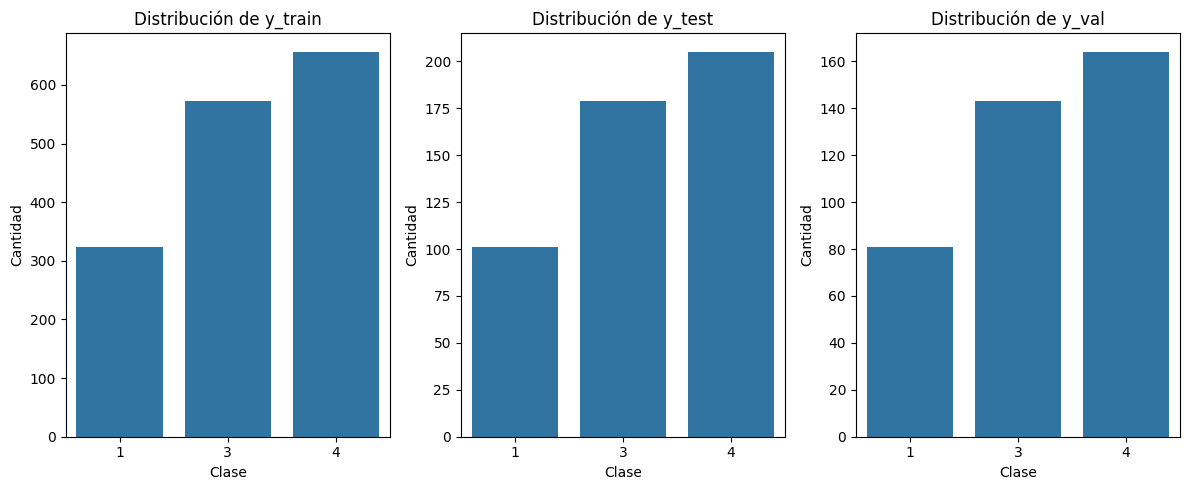

In [229]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Distribución de y_train')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')

sns.countplot(x=y_test, ax=axes[1])
axes[1].set_title('Distribución de y_test')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Cantidad')

sns.countplot(x=y_val, ax=axes[2])
axes[2].set_title('Distribución de y_val')
axes[2].set_xlabel('Clase')
axes[2].set_ylabel('Cantidad')

plt.tight_layout()
plt.show()

Se visualiza que las proporciones se mantuvieron.

Ahora, se procede a vectorizar usando tf-idf con n-gramas de tamaño 1 y 2. Se limita el número máximo de features a 50000, pero igual se encontró que los features no superan este límite, entonces no se perdieron n-gramas. Adicionalmente, eliminan tokens raros, i.e. los que tienen una frecuencia df < 2 para reducir la dimensionalidad y el ruido en los datos.

In [230]:
# Vectorizador elegido: TF-IDF con 1-gramas + 2-gramas
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=50000,   # límite para controlar dimensionalidad (cantidad de features)
    min_df=2,             # ignora tokens muy raros
    norm='l2',
    sublinear_tf=True
)

# Fit solo en train, luego transformar train/test
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)
X_val_tfidf = vectorizer.transform(X_val)

print("Shapes: X_train", X_train_tfidf.shape, "X_test", X_test_tfidf.shape, "X_val", X_val_tfidf.shape)

Shapes: X_train (1551, 12785) X_test (485, 12785) X_val (388, 12785)


In [231]:
feature_names = vectorizer.get_feature_names_out()
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=feature_names, index=X_train.index)
display(X_train_tfidf_df.head())

,abaj,abaj haci,abandon,abandon escol,abandon escuel,abandon estudi,abandon program,abarc,abarqu,abiert,...,xx,xxi,york,york oxford,zeland,zeland tambi,zon,zon remot,zon rural,zon urban
1640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [232]:
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=feature_names, index=X_test.index)
display(X_test_tfidf_df.head())

,abaj,abaj haci,abandon,abandon escol,abandon escuel,abandon estudi,abandon program,abarc,abarqu,abiert,...,xx,xxi,york,york oxford,zeland,zeland tambi,zon,zon remot,zon rural,zon urban
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.117906,0.0,0.0,0.0,0.0,0.0
1220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [233]:
X_val_tfidf_df = pd.DataFrame(X_val_tfidf.toarray(), columns=feature_names, index=X_val.index)
display(X_val_tfidf_df.head())

,abaj,abaj haci,abandon,abandon escol,abandon escuel,abandon estudi,abandon program,abarc,abarqu,abiert,...,xx,xxi,york,york oxford,zeland,zeland tambi,zon,zon remot,zon rural,zon urban
1965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.118819,0.0,0.0,0.0,0.0,0.0


A continuación, se imprimen los n-gramas del primer texto en el conjunto de entrenamiento, junto con sus pesos tf-idf correspondientes para revisar la cualitativamente la vectorización resultante.

In [234]:
lowest_index = X_train_tfidf_df.index.min()
print(f"Texto {lowest_index}: {original_data['textos'].iloc[lowest_index]}")

Texto 0: "Aprendizaje" y "educación" se consideran sinónimos de escolarización formal. Las organizaciones auxiliares, como las editoriales de educación, las juntas examinadoras y las organizaciones de formación de docentes, se consideran extensiones de los acuerdos establecidos por los gobiernos. Este marco de comprensión se ha vuelto cada vez más inadecuado.


In [235]:
row_lowest_index = X_train_tfidf_df.loc[lowest_index]
nonzero_columns = row_lowest_index[row_lowest_index != 0]

print(nonzero_columns)

acuerd              0.183090
aprendizaj          0.119376
auxiliar            0.243112
cad                 0.120434
cad vez             0.178866
comprension         0.197934
consider            0.210005
docent              0.126974
editorial           0.264366
educ                0.141253
escolariz           0.222642
establec            0.139906
examin              0.179879
extension           0.248967
formacion           0.134567
formacion docent    0.216788
formal              0.187843
gobi                0.181989
inadecu             0.219603
junt                0.168443
marc                0.151071
mas                 0.066055
organiz             0.250326
vez                 0.146120
vez mas             0.186598
vuelt               0.248967
vuelt cad           0.275291
Name: 0, dtype: float64


#### **Resumen de Estructuras de Datos Resultantes**

In [236]:
print("Tipado de X's y y's por conjunto:")
print("Train (X, y):", type(X_train), type(y_train))
print("Test (X, y):", type(X_test), type(y_test))
print("Validation (X, y):", type(X_val), type(y_val))

Tipado de X's y y's por conjunto:
Train (X, y): <class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
Test (X, y): <class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
Validation (X, y): <class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


In [237]:
print("Dimensiones de X's y y's por conjunto (train, test, val):")
print("X:", X_train.shape, X_test.shape, X_val.shape)
print("y:", y_train.shape, y_test.shape, y_val.shape)

Dimensiones de X's y y's por conjunto (train, test, val):
X: (1551,) (485,) (388,)
y: (1551,) (485,) (388,)


In [238]:
print("Verificación de cardinalidad total:")
print(X_train.shape[0] + X_test.shape[0] + X_val.shape[0] == original_data.shape[0])

Verificación de cardinalidad total:
True


Los datos preprocesados, pero sin vectorizar están en las series de pandas X_train, X_test, X_val y las etiquetas en los numpy arrays y_train, y_test, y_val.

In [239]:
df_train = X_train_tfidf_df
df_test = X_test_tfidf_df
df_val = X_val_tfidf_df

Los datos vectorizados están en los dataframes df_train, df_test y df_val, pero sus estiquetas siguen en y_train, y_test y y_val.

Se usó tf-idf con 1-gramas y 2-gramas para vectorizar los textos tras hacer normalización, i.e. pasar a minúsculas, cambiar letras con tíldes y acentos a letras normales, eliminar caracteres especiales, eliminar stop words y stemmizar. Se usó train_test_split con stratify para dividir los datos en entrenamiento, test y validación, con un 64% de los datos para entrenamiento, un 20% para test y un 16% para validación, manteniendo las proporciones de porcentaje de registros por clase en cada conjunto de datos.

In [240]:
print(df_train.shape)
display(df_train.head())

(1551, 12785)


,abaj,abaj haci,abandon,abandon escol,abandon escuel,abandon estudi,abandon program,abarc,abarqu,abiert,...,xx,xxi,york,york oxford,zeland,zeland tambi,zon,zon remot,zon rural,zon urban
1640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
print(df_test.shape)
display(df_test.head())

(485, 12785)


,abaj,abaj haci,abandon,abandon escol,abandon escuel,abandon estudi,abandon program,abarc,abarqu,abiert,...,xx,xxi,york,york oxford,zeland,zeland tambi,zon,zon remot,zon rural,zon urban
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.117906,0.0,0.0,0.0,0.0,0.0
1220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [242]:
print(df_val.shape)
display(df_val.head())

(388, 12785)


,abaj,abaj haci,abandon,abandon escol,abandon escuel,abandon estudi,abandon program,abarc,abarqu,abiert,...,xx,xxi,york,york oxford,zeland,zeland tambi,zon,zon remot,zon rural,zon urban
1965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.118819,0.0,0.0,0.0,0.0,0.0


## **Modelado y Evaluación**

### **Algoritmo K-vecinos - Implementado por Juan Miguel Manrique**

Para clasificar un texto , buscamos sus k documentos más parecidos en el conjunto de entrenamiento y votamos su clase.

Las similitudes se miden con una métrica de distancia y el voto puede ser uniforme o ponderado por distancia.

En texto usamos TF-IDF para convertir cada documento en un vector numérico; por defecto scikit-learn lo normaliza con L2, lo que hace muy natural medir la similitud/distancia entre documentos.

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores hiperparámetros encontrados: {'knn__metric': 'cosine', 'knn__n_neighbors': 15, 'knn__weights': 'uniform', 'tfidf__ngram_range': (1, 2)}
CV f1_macro: 0.9646762771561335
------------------ Métricas en train ------------------
accuracy: 0.953
balanced_acc: 0.952
f1_macro: 0.95
f1_weighted: 0.953

Reporte por clase:
               precision    recall  f1-score   support

           1      0.923     0.950     0.937       101
           3      0.950     0.955     0.953       179
           4      0.970     0.951     0.961       205

    accuracy                          0.953       485
   macro avg      0.948     0.952     0.950       485
weighted avg      0.953     0.953     0.953       485



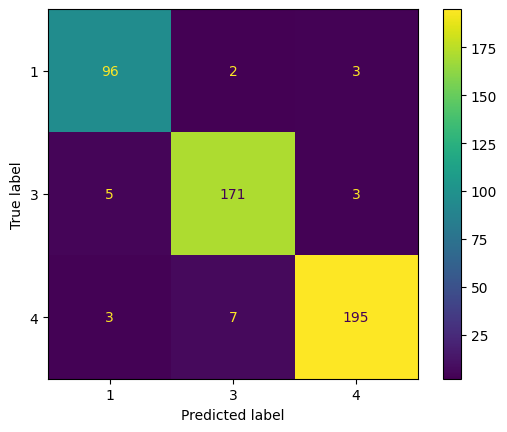

In [243]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score

pipe_knn = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        ngram_range=(1,1),
        min_df=2
    )),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors': [3, 5, 7, 11, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['cosine', 'euclidean']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe_knn, param_grid_knn, scoring='f1_macro', cv=cv, n_jobs=1, verbose=1)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:", grid.best_params_)
print("CV f1_macro:", grid.best_score_)
best_knn = grid.best_estimator_

print("------------------ Métricas en train ------------------")
y_pred_knn = best_knn.predict(X_test)
print("accuracy:", round(accuracy_score(y_test, y_pred_knn), 3))
print("balanced_acc:", round(balanced_accuracy_score(y_test, y_pred_knn), 3))
print("f1_macro:", round(f1_score(y_test, y_pred_knn, average='macro'), 3))
print("f1_weighted:", round(f1_score(y_test, y_pred_knn, average='weighted'), 3))
print("\nReporte por clase:\n", classification_report(y_test, y_pred_knn, digits=3))

cm = confusion_matrix(y_test, y_pred_knn, labels=best_knn.classes_)
ConfusionMatrixDisplay(cm, display_labels=best_knn.classes_).plot(xticks_rotation=0)

#### **Descripción de los resultados**

De acuerdo a la matriz de confusión, se tuvieron para el ODS1, 95/101 aciertos, para el ODS3 174/179 aciertos, y para el ODS4 199/205 aciertos. Los errores son pocos y simétricos, lo que sugiere que el voto por distancia está funcionando bien.

El modelo clasifica con mucha consistencia entre ODS1, ODS3 Y ODS4, con un F1-macro de alrededor 0.961. Como es fácil de explicar, el modelo puede ayudar a tomar decisiones.

Como observación adicional, dado que KNN compara contra muchos textos, la predicción puede volverse más lenta si el histórico crece mucho.

### **Algoritmo Naive-Bayes - Implementado por Sebastian Contreras**

Es un algoritmo de clasificación que se basa en probabilidades.
Se llama Naive,porque asume que todas las características son independientes entre sí, lo cual en la realidad casi nunca es cierto.

Primero, mira como las caracteristicas estan distribuidas en cada clase. Luego calcula las probabilidades para un nuevo dato, calculando la probabilidad de que pertenezca a cada clase, aplicando el teorema de Bayes:

P(Clase|Datos)= P(Datos|Clase)*P(Clase)/P(Datos)

Finalmente, el algoritmo asigna el dato nuevo a la clase que tenga mayor probabilidad posterior.
<!--  -->

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores hiperparámetros encontrados: {'nb__alpha': 0.1, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
CV f1_macro: 0.961

------------------ Métricas en test ------------------
accuracy: 0.963
balanced_acc: 0.958
f1_macro: 0.96
f1_weighted: 0.963

Reporte por clase:
               precision    recall  f1-score   support

           1      0.959     0.931     0.945       101
           3      0.956     0.978     0.967       179
           4      0.971     0.966     0.968       205

    accuracy                          0.963       485
   macro avg      0.962     0.958     0.960       485
weighted avg      0.963     0.963     0.963       485



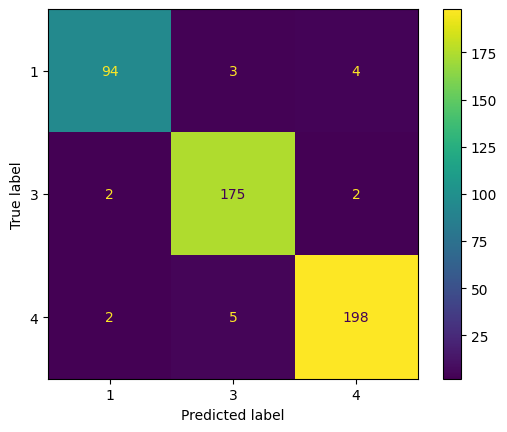

In [244]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, f1_score,
                             balanced_accuracy_score, accuracy_score)

# === Pipeline: TF-IDF -> Naive Bayes ===
pipe_nb = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        strip_accents='unicode',
        ngram_range=(1,1),
        min_df=2
    )),
    ('nb', MultinomialNB())
])

# === Grid MUY corto enfocado en F1-macro ===
param_grid_nb = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [1, 2],
    'nb__alpha': [0.1, 0.5, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe_nb, param_grid_nb, scoring='f1_macro', cv=cv, n_jobs=1, verbose=1)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:", grid.best_params_)
print("CV f1_macro:", round(grid.best_score_, 3))

best_nb = grid.best_estimator_

print("\n------------------ Métricas en test ------------------")
y_pred_nb = best_nb.predict(X_test)
print("accuracy:", round(accuracy_score(y_test, y_pred_nb), 3))
print("balanced_acc:", round(balanced_accuracy_score(y_test, y_pred_nb), 3))
print("f1_macro:", round(f1_score(y_test, y_pred_nb, average='macro'), 3))
print("f1_weighted:", round(f1_score(y_test, y_pred_nb, average='weighted'), 3))
print("\nReporte por clase:\n", classification_report(y_test, y_pred_nb, digits=3))

cm = confusion_matrix(y_test, y_pred_nb, labels=best_nb.classes_)
ConfusionMatrixDisplay(cm, display_labels=best_nb.classes_).plot(xticks_rotation=0)


#### **Descripción de los resultados**

El modelo Naive Bayes Multinomial con TF-IDF alcanzó un F1-macro de 0.961, con una exactitud del 96.3% y métricas equilibradas entre clases (ODS1: 0.95, ODS3: 0.96, ODS4: 0.97). Estos valores muestran que el modelo clasifica de forma confiable y consistente, incluso con el desbalance de datos. Para la organización, esto significa contar con una herramienta precisa para procesar opiniones ciudadanas y transformarlas en información útil para orientar políticas públicas alineadas con los ODS 1, 3 y 4.

#### **Palabras clave y estrategias**
El análisis del modelo evidencia vocabulario característico por cada ODS:

- ODS1 (pobreza): pobreza, ingresos, subsidio, vivienda.

- ODS3 (salud): salud, hospital, paciente, tratamiento.

- ODS4 (educación): escuela, estudiante, docente, aprendizaje.

Esta información permite a la organización comprender cómo se expresan los ciudadanos sobre cada problemática y poder diseñar estrategias focalizadas en por ejemplo, programas de apoyo económico para pobreza, mejoras en infraestructura y atención médica para salud, y políticas de acceso y calidad educativa, entre otras. Además, posibilita un monitoreo continuo de las prioridades sociales, facilitando una respuesta más rápida y basada en evidencia, respectivamente..

### **Algoritmo de Regresión Logística - Implementado por Andrés Felipe Gomez**

In [245]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------
# Configuración
# -------------------------
OUT_DIR = "model_outputs_train_test_only"
os.makedirs(OUT_DIR, exist_ok=True)

# Features y matrices (ya garantizadas por tu notebook)
feature_names = list(df_train.columns)           # nombres de las 12.785 n-gramas
X_train = df_train.values.astype(np.float32)
X_test  = df_test.values.astype(np.float32)
y_train = np.asarray(y_train)
y_test  = np.asarray(y_test)

print("Shapes: X_train", X_train.shape, "X_test", X_test.shape)

# -------------------------
# 1) Búsqueda de hiperparámetros sobre df_train
# -------------------------
clf = LogisticRegression(solver='saga',
                         multi_class='multinomial',
                         max_iter=5000,
                         n_jobs=-1,
                         random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1.0, 5.0],
    'class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring='f1_macro',
                    cv=cv,
                    n_jobs=1,
                    verbose=1)

t0 = time.time()
print("Ejecutando GridSearchCV sobre df_train...")
grid.fit(X_train, y_train)
print(f"GridSearch completado en {time.time() - t0:.1f}s")
print("Mejores parámetros:", grid.best_params_)
print(f"Mejor f1_macro (CV): {grid.best_score_:.4f}")

best_clf = grid.best_estimator_
joblib.dump(best_clf, os.path.join(OUT_DIR, "best_logreg_trained_on_train.joblib"))

# -------------------------
# 2) Evaluación en df_test
# -------------------------
y_pred = best_clf.predict(X_test)
print("\nReporte en df_test:")
print(classification_report(y_test, y_pred, digits=4))

# Matriz de confusión (counts + normalized)
classes = np.unique(y_train)
cm = confusion_matrix(y_test, y_pred, labels=classes)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion matrix (counts) - df_test")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix_test_counts.png"), dpi=150)
plt.close()

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion matrix (normalized) - df_test")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix_test_norm.png"), dpi=150)
plt.close()

# Guardar classification report
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T.to_csv(
    os.path.join(OUT_DIR, "classification_report_test.csv")
)

# -------------------------
# 3) Gráfica Precision/Recall/F1 por clase
# -------------------------
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
class_rows = [str(c) for c in classes]
prf = report_df.loc[class_rows, ['precision','recall','f1-score']].astype(float)

ax = prf.plot(kind='bar', figsize=(8,5))
ax.set_title("Precision / Recall / F1 por clase (df_test)")
ax.set_ylabel("Score"); ax.set_xlabel("Clase")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "prf_by_class_test.png"), dpi=150)
plt.close()

# -------------------------
# 4) Top n-grams por clase (coeficientes)
# -------------------------
if hasattr(best_clf, "coef_"):
    coefs = best_clf.coef_                 # shape (n_classes, n_features)
    classes = best_clf.classes_
    n_top = 20
    rows = []
    for i, cls in enumerate(classes):
        top_idx = np.argsort(coefs[i])[-n_top:][::-1]
        for rank, j in enumerate(top_idx, start=1):
            rows.append({'class': int(cls), 'rank': rank,
                         'ngram': feature_names[j], 'weight': float(coefs[i, j])})
    top_df = pd.DataFrame(rows)
    top_df.to_csv(os.path.join(OUT_DIR, "top_ngrams_per_class_test.csv"), index=False)

    # Guardar matriz completa de coeficientes (opcional pero útil)
    coef_df = pd.DataFrame(coefs, index=[f"class_{c}" for c in classes], columns=feature_names)
    coef_df.to_csv(os.path.join(OUT_DIR, "coef_matrix_test.csv"))
else:
    print("El modelo no tiene coef_. No se extraen n-grams.")

print("\nArtefactos guardados en:", OUT_DIR)

Shapes: X_train (1551, 12785) X_test (485, 12785)
Ejecutando GridSearchCV sobre df_train...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Juan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Juan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Juan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Juan\AppData\Local\Programs\Python\Pytho

GridSearch completado en 113.7s
Mejores parámetros: {'C': 5.0, 'class_weight': 'balanced'}
Mejor f1_macro (CV): 0.9775

Reporte en df_test:
              precision    recall  f1-score   support

           1     0.9500    0.9406    0.9453       101
           3     0.9508    0.9721    0.9613       179
           4     0.9802    0.9659    0.9730       205

    accuracy                         0.9629       485
   macro avg     0.9603    0.9595    0.9599       485
weighted avg     0.9631    0.9629    0.9629       485


Artefactos guardados en: model_outputs_train_test_only


In [246]:
# Análisis automático de "por qué" se cometen errores: comparación FN vs TP por n-gram
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

OUT_DIR = "model_outputs_train_test_only"
os.makedirs(OUT_DIR, exist_ok=True)

# Parámetros
top_k = 20   # cuántos n-grams mostrar en los gráficos/listas
eps = 1e-9

# 1) Predicción y clase con peor recall (igual que antes)
X_test = df_test.values.astype(np.float32)
y_true = np.asarray(y_test)
y_pred = best_clf.predict(X_test)

from sklearn.metrics import classification_report
rep = classification_report(y_true, y_pred, output_dict=True)
class_recalls = {int(k): v['recall'] for k, v in rep.items() if k.isdigit()}
worst_class = min(class_recalls, key=class_recalls.get)
print(f"Clase con peor recall: {worst_class} (recall = {class_recalls[worst_class]:.4f})")

# 2) Máscaras para TP, FN, FP (respecto a worst_class)
mask_true = (y_true == worst_class)
mask_pred = (y_pred == worst_class)
mask_TP = mask_true & mask_pred
mask_FN = mask_true & (~mask_pred)
mask_FP = (~mask_true) & mask_pred

n_TP = mask_TP.sum()
n_FN = mask_FN.sum()
n_FP = mask_FP.sum()
print(f"Nº docs TP={n_TP}, FN={n_FN}, FP={n_FP}")

if n_TP == 0 or n_FN == 0:
    print("Advertencia: no hay suficientes TP o FN para comparar. Revisa los tamaños o ajusta el dataset.")

# 3) Presencia y promedio TF-IDF por n-gramue para cada grupo
# df_test columns son los n-grams; asumimos df_test es DataFrame
feat_names = list(df_test.columns)
presence = (df_test > 0).astype(int)   # DataFrame de 0/1 indicando presencia
tfidf_vals = df_test.astype(float)     # por si queremos promedios

# Sumar presencias y promedios
pres_FN = presence.loc[mask_FN, :].sum(axis=0)        # series index=feature
pres_TP = presence.loc[mask_TP, :].sum(axis=0)
tfidf_FN_mean = tfidf_vals.loc[mask_FN, :].mean(axis=0).fillna(0)
tfidf_TP_mean = tfidf_vals.loc[mask_TP, :].mean(axis=0).fillna(0)

# N docs en cada grupo (evitar división por 0)
n_FN = max(1, n_FN)
n_TP = max(1, n_TP)

rate_FN = pres_FN / n_FN
rate_TP = pres_TP / n_TP

# 4) Construir DataFrame resumen por feature
summary = pd.DataFrame({
    'feature': feat_names,
    'pres_FN': pres_FN.values,
    'pres_TP': pres_TP.values,
    'rate_FN': rate_FN.values,
    'rate_TP': rate_TP.values,
    'tfidf_FN_mean': tfidf_FN_mean.values,
    'tfidf_TP_mean': tfidf_TP_mean.values
})
summary['diff_rate'] = summary['rate_FN'] - summary['rate_TP']          # positivo -> más en FN
summary['ratio_rate'] = (summary['rate_FN'] + eps) / (summary['rate_TP'] + eps)
summary['diff_tfidf'] = summary['tfidf_FN_mean'] - summary['tfidf_TP_mean']
summary = summary.sort_values('diff_rate', ascending=False).reset_index(drop=True)

# Guardar CSV completo
csv_path = os.path.join(OUT_DIR, f"fn_vs_tp_summary_class_{worst_class}.csv")
summary.to_csv(csv_path, index=False)
print(f"Resumen por n-gram guardado en: {csv_path}")

# 5) Mostrar top n-grams más distintivos en FN (model misses) y en TP (model acierta)
top_fn = summary.head(top_k)
top_tp = summary.tail(top_k).sort_values('diff_rate')  # negativo diff_rate -> más en TP

print("\nTop n-grams sobre-representados en FALSOS NEGATIVOS (pueden indicar señales que el modelo ignora):")
for i, row in top_fn.head(20).iterrows():
    print(f"{i+1:2d}. {row['feature'][:50]:50s}  rate_FN={row['rate_FN']:.3f}  rate_TP={row['rate_TP']:.3f}  diff={row['diff_rate']:.3f}  tfidf_diff={row['diff_tfidf']:.3f}")

print("\nTop n-grams sobre-representados en VERDADEROS POSITIVOS (señales que el modelo usa bien):")
for i, row in top_tp.head(20).iterrows():
    print(f"{i+1:2d}. {row['feature'][:50]:50s}  rate_TP={row['rate_TP']:.3f}  rate_FN={row['rate_FN']:.3f}  diff={row['diff_rate']:.3f}  tfidf_diff={row['diff_tfidf']:.3f}")

# 6) Graficar los top_k n-grams (diff_rate)
plt.figure(figsize=(10,6))
sns.barplot(x='diff_rate', y='feature', data=top_fn.head(top_k), palette='Reds_r')
plt.title(f"Top {top_k} n-grams más sobre-representados en FALSOS NEGATIVOS (class {worst_class})")
plt.xlabel("rate_FN - rate_TP")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, f"top_fn_ngrams_class_{worst_class}.png"), dpi=150)
plt.close()

plt.figure(figsize=(10,6))
sns.barplot(x='diff_rate', y='feature', data=top_tp.head(top_k), palette='Greens')
plt.title(f"Top {top_k} n-grams más sobre-representados en VERDADEROS POSITIVOS (class {worst_class})")
plt.xlabel("rate_FN - rate_TP (negativo: more in TP)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, f"top_tp_ngrams_class_{worst_class}.png"), dpi=150)
plt.close()

print(f"\nGráficos guardados en {OUT_DIR} (top_fn_ngrams..., top_tp_ngrams...).")

Clase con peor recall: 1 (recall = 0.9406)
Nº docs TP=95, FN=6, FP=5
Resumen por n-gram guardado en: model_outputs_train_test_only\fn_vs_tp_summary_class_1.csv

Top n-grams sobre-representados en FALSOS NEGATIVOS (pueden indicar señales que el modelo ignora):
 1. embarg                                              rate_FN=0.667  rate_TP=0.179  diff=0.488  tfidf_diff=0.031
 2. servici                                             rate_FN=0.500  rate_TP=0.053  diff=0.447  tfidf_diff=0.040
 3. part                                                rate_FN=0.500  rate_TP=0.147  diff=0.353  tfidf_diff=0.030
 4. sanitari                                            rate_FN=0.333  rate_TP=0.000  diff=0.333  tfidf_diff=0.033
 5. control                                             rate_FN=0.333  rate_TP=0.011  diff=0.323  tfidf_diff=0.029
 6. vieron                                              rate_FN=0.333  rate_TP=0.011  diff=0.323  tfidf_diff=0.050
 7. distint                                       

C:\Users\Juan\AppData\Local\Temp\ipykernel_5732\3090637395.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='diff_rate', y='feature', data=top_fn.head(top_k), palette='Reds_r')
C:\Users\Juan\AppData\Local\Temp\ipykernel_5732\3090637395.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='diff_rate', y='feature', data=top_tp.head(top_k), palette='Greens')



Gráficos guardados en model_outputs_train_test_only (top_fn_ngrams..., top_tp_ngrams...).


## **Resultados**

De acuerdo a las métricas obtenidas por los tres modelos, habiendo usado la partición de datos de prueba X_test y y_test, se encontró que el modelo con el algoritmo Naive-Bayes obtuvo el mejor F1-macro promedio, así como métricas muy equilibradas por clase. Si bien los tres algoritmos rindieron de manera parecida.

De acuerdo a la selección, se utilizará una última partición del conjunto de datos para validar las métricas obtenidas.

### **Métricas en X_val y y_val**

----- Reporte en VALIDACIÓN -----
              precision    recall  f1-score   support

           1      0.951     0.951     0.951        81
           3      0.966     0.986     0.976       143
           4      0.988     0.970     0.978       164

    accuracy                          0.972       388
   macro avg      0.968     0.969     0.968       388
weighted avg      0.972     0.972     0.972       388

accuracy   : 0.972
bal_acc    : 0.969
f1_macro   : 0.968
f1_weighted: 0.972


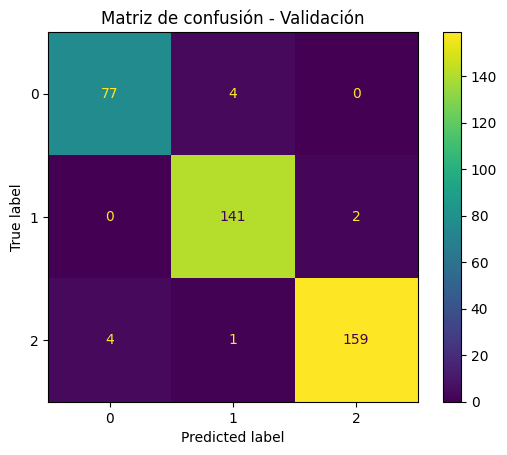

In [247]:
from sklearn.metrics import (
    classification_report, accuracy_score, balanced_accuracy_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

best_model = best_nb

# Predicción en validación
y_val_pred = best_model.predict(X_val)

# Reporte completo
print("----- Reporte en VALIDACIÓN -----")
print(classification_report(y_val, y_val_pred, digits=3))

acc  = accuracy_score(y_val, y_val_pred)
bacc = balanced_accuracy_score(y_val, y_val_pred)
f1m  = f1_score(y_val, y_val_pred, average="macro")
f1w  = f1_score(y_val, y_val_pred, average="weighted")

print(f"accuracy   : {acc:.3f}")
print(f"bal_acc    : {bacc:.3f}")
print(f"f1_macro   : {f1m:.3f}")
print(f"f1_weighted: {f1w:.3f}")

# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d", cmap="viridis")
plt.title("Matriz de confusión - Validación")
plt.show()


### **Curva ROC**

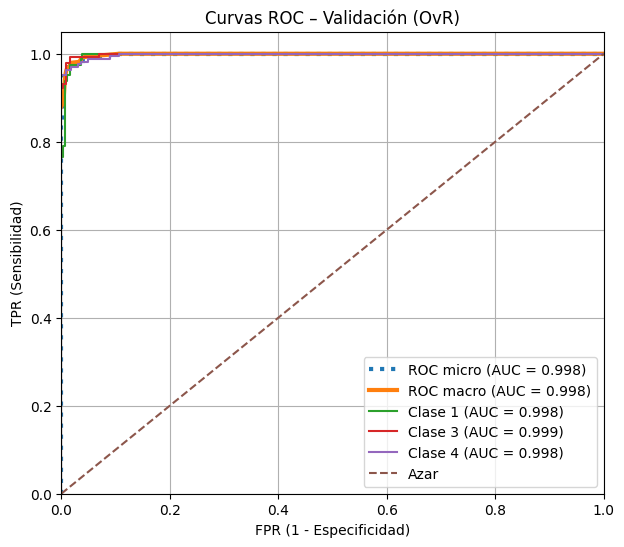

In [248]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# --- Probabilidades en validación ---
proba_val = best_model.predict_proba(X_val) 
classes   = best_model.classes_

# --- Curvas ROC (OvR) con AUC por clase + macro y micro ---
Y_true_bin = label_binarize(y_val, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(Y_true_bin[:, i], proba_val[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_bin.ravel(), proba_val.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)
for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr["micro"], tpr["micro"], linestyle=":", linewidth=3,
         label=f"ROC micro (AUC = {roc_auc['micro']:.3f})")
plt.plot(all_fpr, mean_tpr, linewidth=3,
         label=f"ROC macro (AUC = {roc_auc['macro']:.3f})")

for c in classes:
    plt.plot(fpr[c], tpr[c], label=f"Clase {c} (AUC = {roc_auc[c]:.3f})")

plt.plot([0,1], [0,1], "--", label="Azar")
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel("FPR (1 - Especificidad)"); plt.ylabel("TPR (Sensibilidad)")
plt.title("Curvas ROC – Validación (OvR)")
plt.grid(True); plt.legend(loc="lower right")
plt.show()

### **Descripción de resultados y aporte al objetivo**

Con las métricas de validación se obtuvo:

- Una precisión de 0.972.

- F1-macro de 0.968.

- F1-weighted de 0.972.

Por clase:
- ODS1, pobreza: F1 0.951 (prec. 0.951, rec. 0.951, 81 doc.) Casi no se nos escapan mensajes de pobreza (recall alto), con algunos falsos positivos hacia ODS1.

- ODS3, salud: F1 0.976 (prec. 0.966, rec. 0.986, 143 doc.). Rendimiento muy balanceado.

- ODS4, educación: F1 0.978 (prec. 0.988, rec. 0.970, 164 doc.). Altísima precisión (muy pocos “falsos ODS4”); unos pocos se quedan sin etiquetar como ODS4 (FN).

La matriz de confusíón indica que las confusiones son bajas y se concentran en pares semánticamente cercanos.

Aportes al objetivo del negocio:

- El modelo etiqueta automáticamente las opiniones por ODS con ~96% de acierto y consistencia entre clases (F1-macro 0.968).

- Permite monitorear volumen y tendencias por ODS, priorizar acciones y recursos, y generar alertas tempranas.

- Operación recomendada: para predicciones con baja confianza, enviar a revisión humana; el resto se integra directo a tableros y reportes.

La ROC multiclase (OvR) muestra un desempeño casi ideal: las curvas de las tres clases se pegan al vértice superior–izquierdo y los AUC son micro = 0.998 y macro = 0.998, con AUC por clase 1 = 0.998, 3 = 0.999 y 4 = 0.998. Esto implica que el modelo distingue muy bien cada ODS del resto en un amplio rango de umbrales: podemos alcanzar altas sensibilidades con muy pocas falsas alarmas. El macro-AUC tan alto indica equilibrio entre clases, y el micro-AUC confirma el excelente rendimiento global ponderado por soporte. En síntesis, la ROC respalda lo visto en la matriz de confusión/F1: el clasificador es fiable y estable para priorizar decisiones. Como buen complemento, vale la pena reportar también curvas Precision-Recall y, si el negocio lo requiere, ajustar el umbral para favorecer recall o precisión en una clase específica.

### **Palabras clave y estrategias para la organización**



Extraer palabras clave por clase.

In [249]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.feature_selection import chi2

# 1) Vectorizador dentro del pipeline
vec = best_model.named_steps['tfidf']
vocab = np.array(vec.get_feature_names_out())

# 2) Construir Xtr 
def get_Xtr_alineado(X_like):
    if sp.issparse(X_like) or (hasattr(X_like, "ndim") and X_like.ndim == 2):
        Xtr_local = X_like
        # Validar alineación con el vocabulario del TF-IDF del pipeline
        if Xtr_local.shape[1] != len(vocab):
            raise ValueError(
                f"Desfase de vocabulario: X tiene {Xtr_local.shape[1]} columnas "
                f"y el TF-IDF del pipeline tiene {len(vocab)} términos. "
                "Re-transforma desde texto con el vectorizador del pipeline."
            )
        return Xtr_local
    X_text = pd.Series(X_like).fillna("").astype(str)
    return vec.transform(X_text)

Xtr = get_Xtr_alineado(X_train)
y = np.asarray(y_train)

# 3) Chi-cuadrado por clase
def top_chi2_per_class(X, y, label, top=10):
    chi, _ = chi2(X, (y == label).astype(int))
    idx = np.argsort(chi)[-top:][::-1]
    return pd.DataFrame({"term": vocab[idx], "chi2": chi[idx]})

for lbl in np.sort(np.unique(y)):
    print(f"\nTérminos más discriminativos para clase {lbl}")
    display(top_chi2_per_class(Xtr, y, lbl, top=10))



Términos más discriminativos para clase 1


,term,chi2
0,pobrez,97.620686
1,pobr,42.396216
2,privacion,20.472253
3,tas pobrez,20.028362
4,pobrez infantil,18.999916
5,ingres,18.732807
6,hogar,17.405131
7,umbral,15.804610
8,monetari,15.102757
9,multidimensional,14.678597



Términos más discriminativos para clase 3


,term,chi2
0,salud,39.109604
1,atencion,27.245438
2,medic,26.798292
3,pacient,24.941441
4,mental,19.200344
5,atencion primari,17.037325
6,sanitari,16.497092
7,salud mental,15.501411
8,enfermedad,15.350896
9,pobrez,15.038442



Términos más discriminativos para clase 4


,term,chi2
0,educ,30.531177
1,escuel,29.960008
2,docent,21.920771
3,estudi,21.354895
4,aprendizaj,19.789097
5,pobrez,18.780879
6,salud,18.739396
7,alumn,17.695720
8,ensen,15.213271
9,profesor,13.648016


Se utilizo una Chi-cuadrado por clase para destacar los términos más discriminativos.

- ODS 1 – Pobreza

    - Términos característicos (χ²): pobrez(a), privación, tasa de pobreza, pobreza infantil, ingreso(s), hogar, umbral, monetaria, multidimensional.
    - Qué dicen las opiniones: La conversación gira en torno a ingresos del hogar, línea/umbral de pobreza, carencias multidimensionales y pobreza infantil.
    - Estrategias sugeridas: Apoyos focalizados a hogares bajo el umbral. Programas de empleo y formación en territorios con mayor mención de “ingresos/hogar”. Intervenciones para niñez ante “pobreza infantil”.
    - Cómo usarlo: Priorizar zonas y poblaciones donde crezcan estas menciones; combinar con tableros temporales para activar alertas tempranas.

- ODS 3 – Salud

    - Términos característicos (χ²): salud, atención, médic(o), pacient(e), mental, atención primaria, sanitario, salud mental, enfermedad.
    - Qué dicen las opiniones: Se habla de acceso/atención (primaria) y salud mental; también de capacidad del sistema sanitario.
    - Estrategias sugeridas: Fortalecimiento de la atención primaria (agendas, triage, equipos extramurales) donde suben “atención/primaria”. Programas de salud mental (líneas de apoyo, psicología comunitaria, campañas antiestigma) donde crece “salud mental”. Gestión de demanda hospitalaria y tiempos de espera ante picos en “paciente/enfermedad”.
    - Cómo usarlo: Definir SLA de respuesta (p. ej., si “salud mental” supera cierto umbral en una comuna, activar refuerzo de oferta).

- ODS 4 – Educación
    - Términos característicos (χ²): educ(ación), escuel(a), docent(e), estudi(ante), aprendizaje, alumn(o), enseñ(anza), profesor.
    - Qué dicen las opiniones: Foco en infraestructura escolar, rol docente y resultados de aprendizaje.
    - Estrategias sugeridas: Mejoras de infraestructura y dotación donde se concentran “escuela”. Formación y acompañamiento docente cuando destacan “docente/profesor”. Retención y becas en territorios con más menciones a “alumno/estudiante”. Refuerzo pedagógico (tutorías, currículo flexible) ante énfasis en “aprendizaje/enseñanza”.
    - Cómo usarlo: Mapear estos términos por zona para priorizar inversiones y evaluar impacto.

- ¿Por qué esta información es útil?

    - Interpretabilidad: Las palabras clave explican qué tema concreto está detonando cada etiqueta ODS.
    - Priorización operativa: Facilitan dónde y en qué actuar.
    - Medición de impacto: Permiten seguir la evolución temporal de los términos tras una intervención y ajustar la estrategia.

### **Datos de prueba compartidos**

Con el mejor modelo, se procede a cargar el archivo de datos de prueba compartidos (sin etiquetar) y realizar las clasificaciones. Los resultados se guardan en el archivo: predicciones_ods.xlsx

In [250]:
import numpy as np
import pandas as pd


# ==== Parámetros de entrada/salida ====
TEST_PATH = "data/Datos de prueba_proyecto.xlsx"  
TEXT_COL  = "Textos_espanol"  
OUT_PATH  = "predicciones_ods.xlsx"

# ==== Leer datos de prueba ====
df_test = pd.read_excel(TEST_PATH)

# Si no está la columna TEXT_COL
if TEXT_COL not in df_test.columns:
    obj_cols = [c for c in df_test.columns if df_test[c].dtype == "O"]
    if not obj_cols:
        raise ValueError(
            f"No encuentro columna de texto. Revisa columnas: {list(df_test.columns)}"
        )
    # Heurística simple: la columna de objetos con textos más largos
    TEXT_COL = max(obj_cols, key=lambda c: df_test[c].astype(str).str.len().mean())
    print(f"[Aviso] Usando '{TEXT_COL}' como columna de texto detectada.")

# Normalizar texto (sin nulos)
x_text = df_test[TEXT_COL].fillna("").astype(str)

# ==== Predecir con el mejor modelo ====
y_pred = best_model.predict(x_text)

# guardar confianza si el clasificador expone predict_proba
try:
    proba = best_model.predict_proba(x_text)
    conf  = proba.max(axis=1)
    df_test["confianza"] = np.round(conf, 3)
except Exception:
    df_test["confianza"] = np.nan

# Map de códigos a nombres de ODS
label_map = {1: "ODS1_Pobreza", 3: "ODS3_Salud", 4: "ODS4_Educacion"}

# Columan adicional: etiqueta asignada por el modelo
df_test["etiqueta"] = y_pred
df_test["etiqueta_nombre"] = pd.Series(y_pred).map(label_map).fillna(pd.Series(y_pred).astype(str))

# ==== Guardar a Excel ====
# Requiere openpyxl: pip install openpyxl
df_test.to_excel(OUT_PATH, index=False)
print(f"Archivo escrito: {OUT_PATH}")


Archivo escrito: predicciones_ods.xlsx
